# A Simple Case Study using Wage Data from 2015

We illustrate how to predict an outcome variable Y in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. So far we have used linear prediction rules, e.g. Lasso regression, for estimation.
Now, we also consider nonlinear prediction rules including tree-based methods.

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [33]:
import pandas as pd
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import random
import itertools


import warnings
warnings.filterwarnings('ignore') # eliminar warning messages 

In [34]:
rdata_read = pyreadr.read_r("../../data/wage2015_subsample_inference.Rdata")

# Extracting the data frame from rdata_read
data = rdata_read[ 'data' ]

data.shape

(5150, 20)

In [35]:
data

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
rownames,,,,,,,,,,,,,,,,,,,,
10,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
12,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9
15,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4
18,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12
19,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32620,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9
32624,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20
32626,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6


In [36]:
data = data.reset_index().drop( 'rownames', axis = 1)

In [37]:
data

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
0,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
1,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9
2,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4
3,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12
4,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9
5146,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20
5147,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6
5148,32.967033,3.495508,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,1.00,1.000,1.0000,2920,9,6570,11


The outcomes $Y_i$'s are hourly (log) wages of never-married workers living in the U.S. The raw regressors $Z_i$'s consist of a variety of characteristics, including experience, education and industry and occupation indicators.

In [38]:
Z = data.loc[:, 'sex':'ind2']  # select columns from sex to ind2
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

The following figure shows the weekly wage distribution from the US survey data.

(0.0, 3000.0)

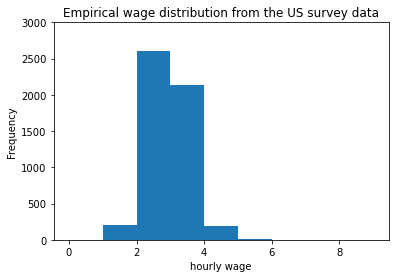

In [39]:
plt.hist(data.lwage , bins = np.arange(0, 10, 1) )
plt.xlabel('hourly wage')
plt.ylabel('Frequency')
plt.title( 'Empirical wage distribution from the US survey data' )
plt.ylim((0, 3000))

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$log(wage) = g(Z) + \epsilon.$$

We will estimate the two sets of prediction rules: Linear and Nonlinear Models.
In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$
Again, we generate $X$ in two ways:
 
1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., ${exp}^2$ and ${exp}^3$) and additional two-way interactions.


To evaluate the out-of-sample performance, we split the data first.

In [40]:
nrow = data.shape[0]
length = int(nrow*(3/4)) # 75% number of observations

In [41]:
from numpy.random import default_rng

random.seed(30)
rng = default_rng()

training = rng.choice(nrow, size = length, replace=False)

training_bool = data.index.isin( training )  # filter using isin

data_train = data[training_bool]
data_test = data[~training_bool]

In [42]:
data_train

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
0,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
2,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4
3,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12
5,11.730769,2.462215,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.01,0.001,0.0001,1650,5,7460,14
6,19.230769,2.956512,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,42.0,17.64,74.088,311.1696,5120,17,7280,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9
5146,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20
5147,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6
5148,32.967033,3.495508,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,1.00,1.000,1.0000,2920,9,6570,11


In [43]:
data_train.shape

(3862, 20)

In [44]:
data_test.shape

(1288, 20)

We construct the two different model matrices $X_{basic}$ and $X_{flex}$ for both the training and the test sample:

In [45]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [46]:
formula_basic =  "lwage ~ sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
formula_flex = "lwage ~ sex + exp1 + exp2 + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"

y_basic_train, model_X_basic_train = patsy.dmatrices(formula_basic, data_train, return_type='dataframe')

In [47]:
model_X_basic_train

,Intercept,occ2[T.10],occ2[T.11],occ2[T.12],occ2[T.13],occ2[T.14],occ2[T.15],occ2[T.16],occ2[T.17],occ2[T.18],...,sex,exp1,exp2,shs,hsg,scl,clg,mw,so,we
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,7.0,0.49,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.0,3.24,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,25.0,6.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.01,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,42.0,17.64,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,9.0,0.81,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5146,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,12.0,1.44,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5147,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,11.0,1.21,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,1.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [48]:
formula_basic =  "lwage ~ sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
formula_flex = "lwage ~ sex + exp1 + exp2 + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"

y_basic_train, model_X_basic_train = patsy.dmatrices(formula_basic, data_train, return_type='dataframe')
y_basic_test, model_X_basic_test = patsy.dmatrices(formula_basic, data_test, return_type='dataframe')
p_basic = model_X_basic_train.shape[ 1 ]

y_flex_train, model_X_flex_train = patsy.dmatrices(formula_flex, data_train, return_type='dataframe')
y_flex_test, model_X_flex_test = patsy.dmatrices(formula_flex, data_test, return_type='dataframe')
p_flex = model_X_flex_train.shape[ 1 ]

In [49]:
# number of regressors

print(p_basic)
print(p_flex)

52
246


In [50]:
Y_train = data_train['lwage']
Y_test = data_test['lwage']

As known from our first lab, the basic model consists of $52$ regressors and the flexible model of $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression. 

### OLS

We fit the basic model to our training data by running an ols regression and compute the mean squared error on the test sample.

In [51]:
# ols (basic model)
lm_basic = sm.OLS( Y_train, model_X_basic_train )
fit_lm_basic = lm_basic.fit()

# Compute the Out-Of-Sample Performance
yhat_lm_basic = fit_lm_basic.predict( model_X_basic_test )

print( f"The mean squared error (MSE) using the basic model is equal to , {np.mean((Y_test-yhat_lm_basic)**2)} ") # MSE OLS (basic model)    

The mean squared error (MSE) using the basic model is equal to , 0.21806632090453132 


To determine the out-of-sample $MSE$ and the standard error in one step, we can use the function *lm*:

In [52]:
resid_basic = (Y_test-yhat_lm_basic)**2

MSE_lm_basic = sm.OLS( resid_basic , np.ones( resid_basic.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_basic

Coef.       0.218066
Std.Err.    0.012180
Name: const, dtype: float64

We also compute the out-of-sample $R^2$:

In [53]:
R2_lm_basic = 1 - ( MSE_lm_basic[0]/Y_test.var() )
print( f"The R^2 using the basic model is equal to, {R2_lm_basic}" ) # MSE OLS (basic model) 

The R^2 using the basic model is equal to, 0.2882981400313489


We repeat the same procedure for the flexible model.

In [54]:
# ols (flex model)
lm_flex = sm.OLS( Y_train, model_X_flex_train )
fit_lm_flex = lm_flex.fit()

yhat_lm_flex = fit_lm_flex.predict( model_X_flex_test )

resid_flex = (Y_test-yhat_lm_flex)**2

MSE_lm_flex = sm.OLS( resid_flex , np.ones( resid_flex.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_flex

R2_lm_flex = 1 - ( MSE_lm_flex[0]/Y_test.var() )

print( f"The mean squared error (MSE) using theflexible model is equal to , {np.mean((Y_test-yhat_lm_flex)**2)} ") 
print( f"The R^2 using the flex model is equal to, {R2_lm_flex}" ) # MSE OLS (flex model) 

The mean squared error (MSE) using theflexible model is equal to , 0.2333588052856049 
The R^2 using the flex model is equal to, 0.23838814231869676


We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We are proceeding by running lasso regressions and its versions.

### Lasso, Ridge and Elastic Net


Considering the basic model, we run a lasso/post-lasso regression first and then we compute the measures for the out-of-sample performance. Note that applying the package *hdm* and the function *rlasso* we rely on a theoretical based choice of the penalty level $\lambda$ in the lasso regression.

In [55]:
import hdmpy

In [56]:
fit_rlasso = hdmpy.rlasso( model_X_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post = hdmpy.rlasso( model_X_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

#### Estimating the predictions from rlasso models
We have to know that the residuals output come from this formula:

- x1 = x - np.ones( (x.shape[1] , 1) ) @ x.mean( axis = 0 )
- beta = model.est['beta'].loc[ fit_rlasso.est['index'].iloc[:, 0].to_list(), ].to_numpy()
- y1 = y - y.mean()
- yhat = x1 @ beta + y.mean()

So we have to apply those transfomations to original test data


In [57]:
# Getting mean of each variable
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_basic_test.to_numpy() - \
                    (np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)


# Getting the significant variables
x1_est_rlasso = new_x1[ :, fit_rlasso.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso = fit_rlasso.est['beta'].loc[ fit_rlasso.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()



# yhat
yhat_rlasso = (x1_est_rlasso @ beta_rlasso) + np.mean( Y_test.to_numpy() )
residuals_rlasso = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso

In [58]:
# Post Lasso

# Getting mean of each variable
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_basic_test.to_numpy() - \
                    (np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post = new_x1[ :, fit_rlasso_post.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post = fit_rlasso_post.est['beta'].loc[ fit_rlasso_post.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post = (x1_est_rlasso_post @ beta_rlasso_post) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post

In [59]:
MSE_lasso = sm.OLS( ( residuals_rlasso )**2 , np.ones( yhat_rlasso.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post = sm.OLS( ( residuals_rlasso_post )**2  , np.ones( yhat_rlasso_post.size )  ).fit().summary2().tables[1].round(3)

R2_lasso = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post = 1 - MSE_lasso_post.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso},for lasso and {R2_lasso_post} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.25203323177120174,for lasso and 0.25529946220014843 for post-lasso


Now, we repeat the same procedure for the flexible model.

In [60]:
fit_rlasso_flex = hdmpy.rlasso( model_X_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post_flex = hdmpy.rlasso( model_X_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

In [61]:
# Getting mean of each variable
meanx = model_X_flex_test.mean( axis = 0 ).values.\
                        reshape( model_X_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_flex_test.to_numpy() - \
                    (np.ones( ( model_X_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_flex = new_x1[ :, fit_rlasso_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_flex = fit_rlasso_flex.est['beta'].loc[ fit_rlasso_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_flex = (x1_est_rlasso_flex @ beta_rlasso_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_flex

In [62]:
# Getting mean of each variable
meanx = model_X_flex_test.mean( axis = 0 ).values.\
                        reshape( model_X_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_flex_test.to_numpy() - \
                    (np.ones( ( model_X_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post_flex = new_x1[ :, fit_rlasso_post_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post_flex = fit_rlasso_post_flex.est['beta'].loc[ fit_rlasso_post_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post_flex = (x1_est_rlasso_post_flex @ beta_rlasso_post_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post_flex

In [63]:
MSE_lasso_flex = sm.OLS( ( residuals_rlasso_flex )**2 , np.ones( yhat_rlasso_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post_flex = sm.OLS( ( residuals_rlasso_post_flex )**2  , np.ones( yhat_rlasso_post_flex.size )  ).fit().summary2().tables[1].round(3)

R2_lasso_flex = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post_flex = 1 - MSE_lasso_post_flex.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso_flex} for lasso and {R2_lasso_post_flex} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.25203323177120174 for lasso and 0.24550077091330824 for post-lasso


It is worth to notice that lasso regression works better for the more complex model.

In contrast to a theoretical based choice of the tuning parameter $\lambda$ in the lasso regression, we can also use cross-validation to determine the penalty level by applying the package *glmnet* and the function cv.glmnet. In this context, we also run a ridge and a elastic net regression by adjusting the parameter *alpha*.

In [64]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV
import statsmodels.api as sm

In [65]:
# Reshaping Y variable
Y_vec = Y_train.to_numpy().reshape(-1, 1)

# Regressions

# normalize = TRUE for standarize features 

fit_lasso_cv_basic = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( model_X_basic_train, Y_vec )

fit_ridge_basic = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( model_X_basic_train , Y_vec )
fit_elnet_basic = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( model_X_basic_train , Y_vec )

# Predictions

yhat_lasso_cv_basic = fit_lasso_cv_basic.predict( model_X_basic_test ).reshape(-1, 1) 
yhat_ridge_basic = fit_ridge_basic.predict( model_X_basic_test ).reshape(-1, 1) 
yhat_elnet_basic = fit_elnet_basic.predict( model_X_basic_test ).reshape(-1, 1) 

In [66]:
MSE_lasso_cv_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_lasso_cv_basic)**2 ) , np.ones( yhat_lasso_cv_basic.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_ridge_basic)**2 ) , np.ones( yhat_ridge_basic.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_elnet_basic)**2 ) , np.ones( yhat_elnet_basic.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [67]:
R2_lasso_cv_basic = 1- MSE_ridge_basic.iloc[0,0] / np.var( Y_test )
R2_ridge_basic = 1- MSE_lasso_cv_basic.iloc[0,0] / np.var( Y_test )
R2_elnet_basic = 1- MSE_elnet_basic.iloc[0,0] / np.var( Y_test )

In [68]:
print( f"R^2 using cross-validation for lasso, ridge and elastic net in the basic model: {R2_lasso_cv_basic},{R2_ridge_basic},{R2_elnet_basic}")

R^2 using cross-validation for lasso, ridge and elastic net in the basic model: 0.007065949600198018,0.2879617664896157,0.2879617664896157


In [69]:
# Reshaping Y variable
Y_vec = Y_train.to_numpy().reshape( -1, 1)

# Regressions
fit_lasso_cv_flex = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( model_X_flex_train, Y_vec )
fit_ridge_flex = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( model_X_flex_train , Y_vec )
fit_elnet_flex = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( model_X_flex_train , Y_vec )

# Predictions
yhat_lasso_cv_flex = fit_lasso_cv_flex.predict( model_X_flex_test ).reshape(-1,1) 
yhat_ridge_flex = fit_ridge_flex.predict( model_X_flex_test ).reshape(-1,1) 
yhat_elnet_flex = fit_elnet_flex.predict( model_X_flex_test ).reshape(-1,1) 

In [70]:
MSE_lasso_cv_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_lasso_cv_flex)**2 ) , np.ones( yhat_lasso_cv_flex.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_ridge_flex)**2 ) , np.ones( yhat_ridge_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_elnet_flex)**2 ) , np.ones( yhat_elnet_flex.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [71]:
R2_lasso_cv_flex = 1- MSE_ridge_flex.iloc[0,0] / np.var( Y_test )
R2_ridge_flex = 1- MSE_lasso_cv_flex.iloc[0,0] / np.var( Y_test )
R2_elnet_flex = 1- MSE_elnet_flex.iloc[0,0] / np.var( Y_test )

In [72]:
print( f"R^2 using cross-validation for lasso, ridge and elastic net in the basic model: {R2_lasso_cv_flex},{R2_ridge_flex},{R2_elnet_flex}")

R^2 using cross-validation for lasso, ridge and elastic net in the basic model: 0.016864640887038096,0.2814293056317222,0.2814293056317222


The performance of the lasso regression with cross-validated penalty is quite similar to the performance of lasso using a theoretical based choice of the tuning parameter.

## Non-linear models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are applying regression trees, random forests, boosted trees and neural nets to estimate the regression function $g(X)$. 


## Regression Trees

We fit a regression tree to the training data using the basic model. The variable *cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

In [73]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from scipy.sparse import diags
from IPython.display import Image, display
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

### scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [74]:
trees = DecisionTreeRegressor( random_state = 0 )

In [75]:
trees_fit =  trees.fit( model_X_basic_train, y_basic_train )

In [76]:
# What attributes save 

dir(trees_fit)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_prune_tree',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_X_predict',
 '_validate_data',
 'apply',
 'ccp_alpha',
 'class_weight',
 'cost_complexity_pruning_path',
 'criterion',
 'decision_path',
 'feature_importances_',
 'feature_names_in_',
 'fit',
 'get_depth',
 'get_n_leaves',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_

In [77]:
# some random tree atributes

print( trees_fit.get_depth() ) # tree's depth  

trees_fit.get_n_leaves() # number of leaves

44


3531

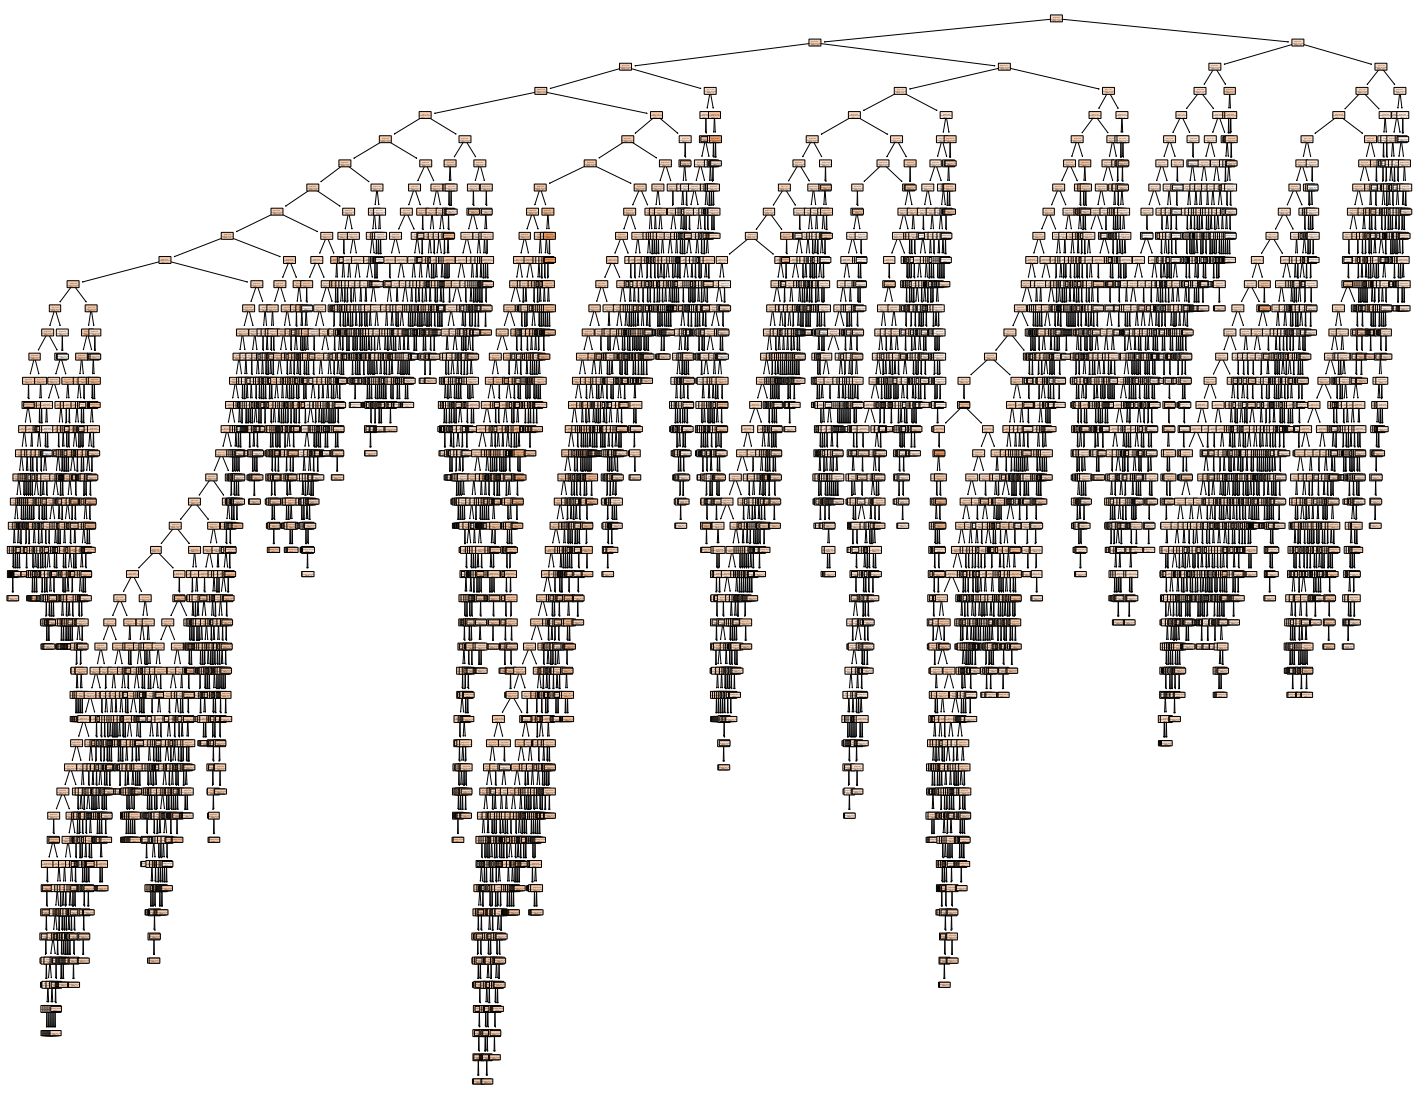

In [78]:
# tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree( trees_fit , filled = True , rounded = True  )

An important method to improve predictive performance is called "Pruning the Tree". This
means the process of cutting down the branches of a tree. We apply pruning to the complex tree above to reduce the depth. Initially, we determine the optimal complexity of the regression tree.

In [79]:
path = trees.cost_complexity_pruning_path( model_X_basic_train, y_basic_train  )
path

{'ccp_alphas': array([ 0.00000000e+00, -9.19915505e-19,  4.59957752e-19, ...,
         4.80536359e-03,  6.28308453e-03,  1.96740837e-02]),
 'impurities': array([0.01147266, 0.01147266, 0.01147266, ..., 0.28582497, 0.29210806,
        0.33145622])}

In [93]:
index = np.where(path['ccp_alphas'] >= 0 )

alphas_tree = pd.Series( path['ccp_alphas'][index] , name = "alphas").unique()

alphas_tree

array([0.00000000e+00, 4.59957752e-19, 9.19915505e-19, ...,
       4.80536359e-03, 6.28308453e-03, 1.96740837e-02])

In [94]:
#Here we create a loop to get an arrange with all Mean Squared Errors for each cp_alpha

mse_gini = []
cp_table_size = []

for i in alphas_tree:
    dtree = DecisionTreeRegressor( ccp_alpha=i, random_state = 0)
    dtree.fit( model_X_basic_train, y_basic_train )
    pred = dtree.predict(model_X_basic_test)
    mse_gini.append(mean_squared_error( y_basic_test , pred))
    cp_table_size.append(dtree.tree_.node_count)

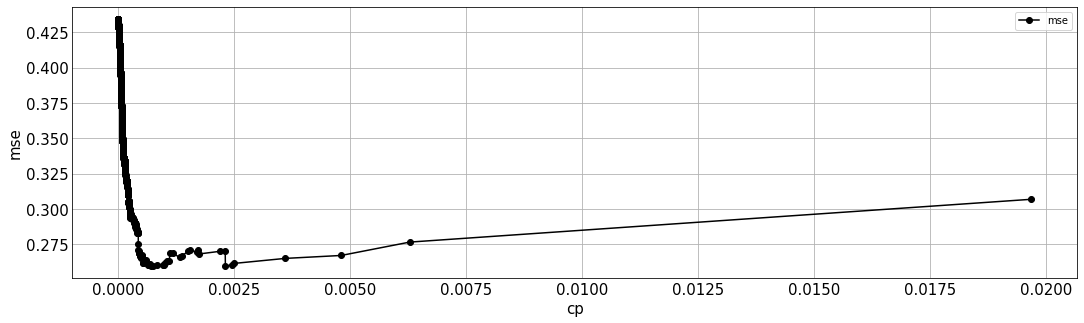

In [95]:
d2 = pd.DataFrame({'acc_gini':pd.Series(mse_gini),'ccp_alphas':pd.Series(alphas_tree)})

# visualizing changes in parameters

plt.figure(figsize=(18,5), facecolor = "white")
plt.plot('ccp_alphas','acc_gini', data=d2, label='mse', marker="o", color='black')

plt.tick_params( axis='x', labelsize=15, length=0, labelrotation=0)
plt.tick_params( axis='y', labelsize=15, length=0, labelrotation=0)
plt.grid()

plt.xlabel('cp', fontsize = 15)
plt.ylabel('mse', fontsize = 15)
plt.legend()

# the optimal cp - alpha reduces the MSE

In [96]:
#It is a function to get the best max_depth parametor with cross-validation
def prune_max_depth(X, y, nfold=10):
    cv_mean_mse = []
    max_depth = []
     # Num ob observations
    nobs = y.shape[0]
    
    # Define folds indices 
    list_1 = [*range(0, nfold, 1)]*nobs
    sample = np.random.choice(nobs,nobs, replace=False).tolist()
    foldid = [list_1[index] for index in sample]

    # Create split function(similar to R)
    def split(x, f):
        count = max(f) + 1
        return tuple( list(itertools.compress(x, (el == i for el in f))) for i in range(count) ) 

    # Split observation indices into folds 
    list_2 = [*range(0, nobs, 1)]
    I = split(list_2, foldid)
    
    for i in range(1,20):
        max_depth.append(i)
        mse_depth = []
        dtree = DecisionTreeRegressor( max_depth=i, random_state = 0)
        
        for b in range(0,len(I)):
            
            # Split data - index to keep are in mask as booleans
            include_idx = set(I[b])  #Here should go I[b] Set is more efficient, but doesn't reorder your elements if that is desireable
            mask = np.array([(a in include_idx) for a in range(len(y))])
            
            dtree.fit(X[~mask], y[~mask])
            pred = dtree.predict(X[mask])
            mse_depth.append(mean_squared_error(y[mask],pred))
            
        mse = np.mean(mse_depth)
        cv_mean_mse.append(mse)
    
    d1 = pd.DataFrame({'acc_depth':pd.Series(cv_mean_mse),'max_depth':pd.Series(max_depth)})
    return d1

In [97]:
# dataframe mse by each max_depth

d1 = prune_max_depth( model_X_basic_train, y_basic_train )

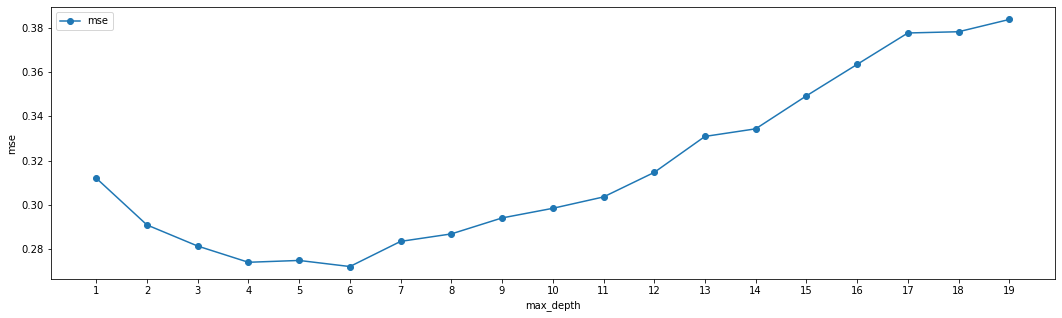

In [98]:
# visualizing changes in parameters
plt.figure(figsize=(18,5))
plt.plot('max_depth','acc_depth', data=d1, label='mse', marker="o")
plt.xticks(np.arange(1,20))

plt.xlabel('max_depth')
plt.ylabel('mse')
plt.legend()

In [99]:
# We get the best parameters

best_max_depth = d1[d1["acc_depth"] == np.min(d1["acc_depth"])].iloc[0,1]
best_ccp = d2[d2["acc_gini"] == np.min(d2["acc_gini"])].iloc[0,1]

# Prune the tree

dt = DecisionTreeRegressor(max_depth=best_max_depth , ccp_alpha= best_ccp , random_state=0)
tree1 = dt.fit( model_X_basic_train, y_basic_train )

[Text(0.6411290322580645, 0.9285714285714286, 'hsg <= 0.5\nsquared_error = 0.331\nsamples = 3862\nvalue = 2.978'),
 Text(0.4112903225806452, 0.7857142857142857, 'scl <= 0.5\nsquared_error = 0.334\nsamples = 2915\nvalue = 3.058'),
 Text(0.24193548387096775, 0.6428571428571429, 'shs <= 0.5\nsquared_error = 0.323\nsamples = 1855\nvalue = 3.18'),
 Text(0.16129032258064516, 0.5, 'exp1 <= 11.5\nsquared_error = 0.298\nsamples = 1770\nvalue = 3.205'),
 Text(0.0967741935483871, 0.35714285714285715, 'occ2[T.17] <= 0.5\nsquared_error = 0.269\nsamples = 1139\nvalue = 3.129'),
 Text(0.06451612903225806, 0.21428571428571427, 'occ2[T.8] <= 0.5\nsquared_error = 0.266\nsamples = 1039\nvalue = 3.157'),
 Text(0.03225806451612903, 0.07142857142857142, 'squared_error = 0.267\nsamples = 913\nvalue = 3.193'),
 Text(0.0967741935483871, 0.07142857142857142, 'squared_error = 0.177\nsamples = 126\nvalue = 2.894'),
 Text(0.12903225806451613, 0.21428571428571427, 'squared_error = 0.205\nsamples = 100\nvalue = 2.83

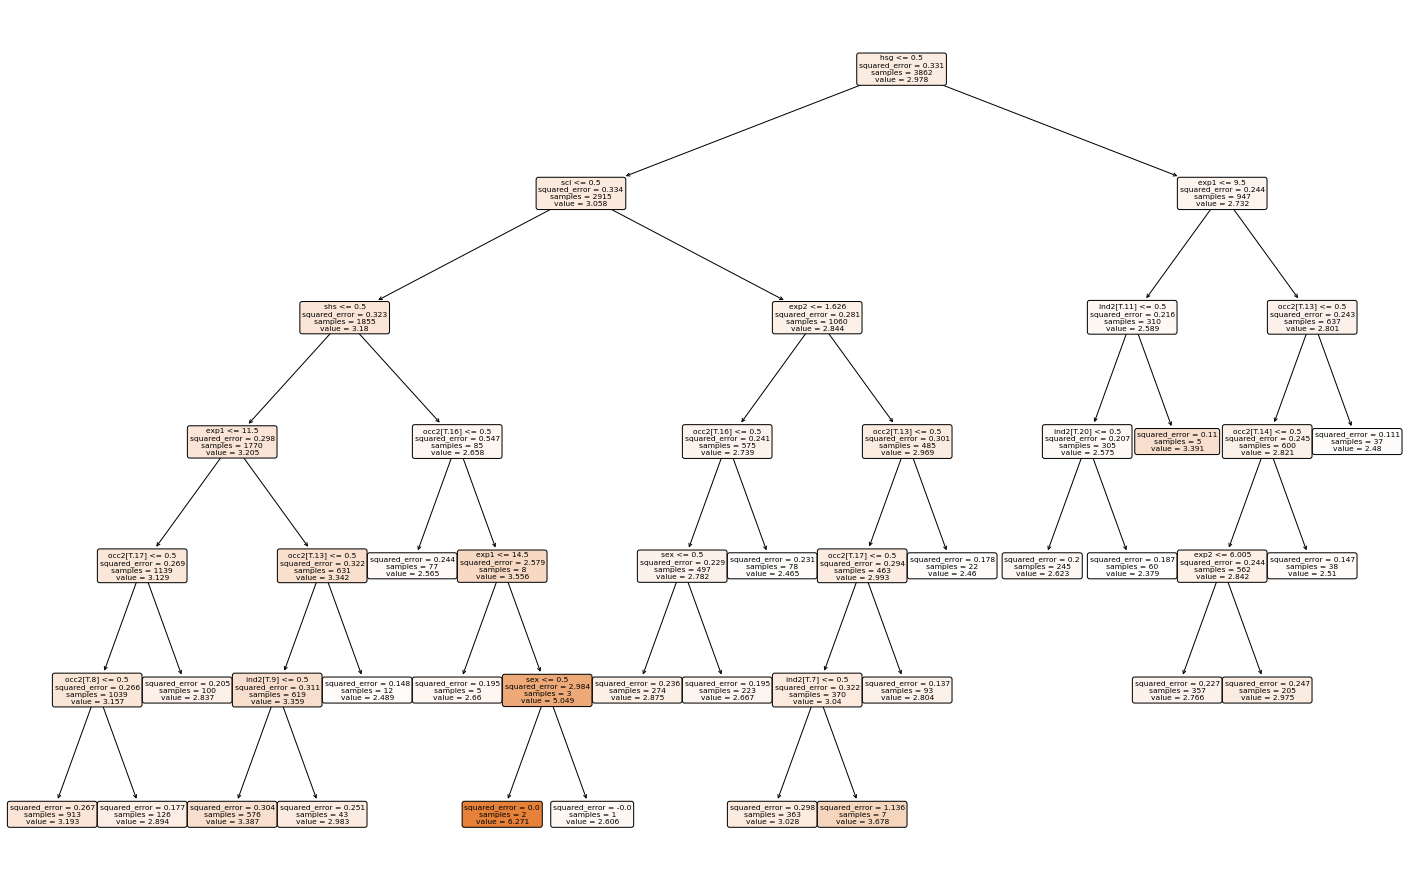

In [100]:
plt.figure(figsize=(25,16))
tree.plot_tree(dt, filled=True, rounded=True, feature_names = model_X_basic_train.columns)

In [101]:
y_hat_pt = dt.predict(model_X_basic_test)

MSE_pt= sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - y_hat_pt.reshape(-1,1))**2 ) , np.ones( y_hat_pt.shape )  ).fit().summary2().tables[1].round(3)
R2_pt = 1- MSE_pt.iloc[0,0] / np.var( Y_test )

print( f"R^2 using prune tree: {R2_pt}")

R^2 using prune tree: 0.1507800884738535


### Random Forest and Boosted Trees

In the next step, we apply the more advanced tree-based methods random forest and boosted trees.

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### Sources:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [103]:
fit_rf = RandomForestRegressor( random_state = 0 , n_estimators = 500 , max_features = "sqrt" , n_jobs = 4 , min_samples_leaf = 5 ).fit( model_X_basic_train, y_basic_train )
fit_boost = GradientBoostingRegressor( random_state = 0 , n_estimators = 500 , max_features = p_basic , min_samples_leaf = 5 ).fit( model_X_basic_train, y_basic_train )

# N_estimators = number of trees

In [104]:
y_hat_rf = fit_rf.predict(model_X_basic_test)
y_hat_boost = fit_boost.predict(model_X_basic_test)

MSE_rf= sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - y_hat_rf.reshape(-1,1))**2 ) , np.ones( y_hat_rf.shape )  ).fit().summary2().tables[1].round(3)
R2_rf = 1- MSE_rf.iloc[0,0] / np.var( Y_test )

MSE_boost= sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - y_hat_boost.reshape(-1,1))**2 ) , np.ones( y_hat_boost.shape )  ).fit().summary2().tables[1].round(3)
R2_boost = 1- MSE_boost.iloc[0,0] / np.var( Y_test )

To conclude, let us have a look at our results.

## Results

In [105]:
table= np.zeros( (15, 3) )
table[0,0:2]   = MSE_lm_basic
table[1,0:2]   = MSE_lm_flex
table[2,0:2]   = MSE_lasso.iloc[0, [0, 1]]
table[3,0:2]   = MSE_lasso_post.iloc[0, [0, 1]]
table[4,0:2]   = MSE_lasso_flex.iloc[0, [0, 1]]
table[5,0:2]   = MSE_lasso_post_flex.iloc[0, [0, 1]]
table[6,0:2]   = MSE_lasso_cv_basic.iloc[0, [0, 1]]
table[7,0:2]   = MSE_ridge_basic.iloc[0, [0, 1]]
table[8,0:2]   = MSE_elnet_basic.iloc[0, [0, 1]]
table[9,0:2]   = MSE_lasso_cv_flex.iloc[0, [0, 1]]
table[10,0:2]  = MSE_ridge_flex.iloc[0, [0, 1]]
table[11,0:2]  = MSE_elnet_flex.iloc[0, [0, 1]]
table[12,0:2]  = MSE_rf.iloc[0, [0, 1]]
table[13,0:2]  = MSE_boost.iloc[0, [0, 1]]
table[14,0:2]  = MSE_pt.iloc[0, [0, 1]]



table[0,2]   = R2_lm_basic
table[1,2]   = R2_lm_flex
table[2,2]   = R2_lasso
table[3,2]   = R2_lasso_post
table[4,2]   = R2_lasso_flex
table[5,2]   = R2_lasso_post_flex
table[6,2]   = R2_lasso_cv_basic
table[7,2]   = R2_ridge_basic
table[8,2]   = R2_elnet_basic
table[9,2]   = R2_lasso_cv_flex
table[10,2]  = R2_ridge_flex
table[11,2]  = R2_elnet_flex
table[12,2]  = R2_rf
table[13,2]  = R2_boost
table[14,2]  = R2_pt




colnames_table= ["MSE", "S_E_ for MSE", "R-squared"]
rownames_table= ["Least Squares (basic)","Least Squares (flexible)", "Lasso", "Post-Lasso","Lasso (flexible)","Post-Lasso (flexible)", \
                    "Cross-Validated lasso", "Cross-Validated ridge","Cross-Validated elnet","Cross-Validated lasso (flexible)","Cross-Validated ridge (flexible)","Cross-Validated elnet (flexible)",  \
                    "Random Forest","Boosted Trees", "Pruned Tree"]
table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round(3)
table_html = table_pandas.to_latex()
table_pandas

,MSE,S_E_ for MSE,R-squared
Least Squares (basic),0.218,0.012,0.288
Least Squares (flexible),0.233,0.013,0.238
Lasso,0.229,0.012,0.252
Post-Lasso,0.228,0.012,0.255
Lasso (flexible),0.230,0.012,0.252
Post-Lasso (flexible),0.231,0.012,0.246
Cross-Validated lasso,0.218,0.012,0.007
Cross-Validated ridge,0.304,0.015,0.288
Cross-Validated elnet,0.218,0.012,0.288
Cross-Validated lasso (flexible),0.220,0.012,0.017
